In [1]:
from __future__ import print_function
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
from cifar10_data import load_cifar10
# import lasagne_trainer

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, CuDNN 4007)
/home/saurabh/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# set up plots

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# get data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-batches-py/")
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3, 32, 32)
Test labels shape:  (10000,)


In [4]:
X_val = X_test
y_val = y_test

In [5]:
input_var = T.tensor4('inputs')

In [6]:
def create_v1(input_var, input_shape=(3, 32, 32),
              ccp_num_filters=[64, 128], ccp_filter_size=3,
              fc_num_units=[128, 128], num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-conv-relu-pool layers
    for num_filters in ccp_num_filters:
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # fc-relu
    for num_units in fc_num_units:
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=num_units,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

In [7]:
param = dict(ccp_num_filters=[64, 128], 
             ccp_filter_size=3,
             fc_num_units=[256, 256],
             num_classes=10)

In [8]:
network = create_v1(input_var, **param)

In [9]:
def gen_minibatches(X, y, batch_size, shuffle=False):
    assert len(X) == len(y), "Training data sizes don't match"
    if shuffle:
        ids = np.random.permutation(len(X))
    else:
        ids = np.arange(len(X))
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        ii = ids[start_idx:start_idx + batch_size]
        yield X[ii], y[ii]

In [10]:
# Training params
learning_rate = .01 
learning_rate_decay=0.5
decay_after_epochs=10

momentum=0.9
momentum_decay=0.5 

regu=0.0
batch_size=128 
num_epochs=25
save_path=None


print("Compiling...")

# Training Prediction
target_var = T.ivector('target')
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
regu_loss = lasagne.regularization.regularize_network_params(
    network, lasagne.regularization.l2)
loss = loss + regu * regu_loss
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                   dtype=theano.config.floatX)
learning_rate_var = theano.shared(np.float32(learning_rate))
# momentum_var = theano.shared(np.float32(momentum))
params = lasagne.layers.get_all_params(network, trainable=True)

updates = lasagne.updates.sgd(
    loss, params, learning_rate=learning_rate_var)

# Test prediction
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)
train_acc_fn = theano.function([input_var, target_var], train_acc)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

### All compilation done 

print("Training...")
best_val_acc = 0.0
best_model = None
loss_history = []
loss_test_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # train model for one pass
    train_err = train_batches = 0
    start_time = time.time()
    for X_batch, y_batch in gen_minibatches(X_train, y_train,
                                            batch_size, shuffle=True):
        err = train_fn(X_batch, y_batch)
        train_err += err
        train_batches += 1
        loss_history.append(err)
        
    # training accuracy
    n_acc = len(y_val)
    trval_err = trval_acc = trval_batches = 0
    for X_batch, y_batch in gen_minibatches(X_train[:n_acc], y_train[:n_acc],
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        trval_err += err
        trval_acc += acc
        trval_batches += 1
    trval_acc /= trval_batches
    train_acc_history.append(trval_acc)
    
    # validation accuracy
    val_err = val_acc = val_batches = 0
    for X_batch, y_batch in gen_minibatches(X_val, y_val,
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        val_err += err
        val_acc += acc
        val_batches += 1
        loss_test_history.append(err)
    val_acc /= val_batches
    val_acc_history.append(val_acc)
    
    
    print('epoch %d / %d in %.1fs: loss %f, train: %.3f, val %.3f, lr %e test_loss %e'
          % (epoch + 1, num_epochs, time.time() - start_time,
             train_err / train_batches, trval_acc, val_acc,
             learning_rate_var.get_value(), val_err/val_batches))
    
    # decay learning rate
    if (epoch + 1) % decay_after_epochs == 0:
        learning_rate_var.set_value(
            np.float32(learning_rate_var.get_value() * learning_rate_decay))
#         momentum = (1.0 - (1.0 - momentum_var.get_value()) * momentum_decay) \
#                    .clip(max=0.9999)
#         momentum_var.set_value(np.float32(momentum))


Compiling...
Training...
epoch 1 / 25 in 58.2s: loss 2.212988, train: 0.287, val 0.292, lr 1.000000e-02 test_loss 1.973428e+00
epoch 2 / 25 in 58.3s: loss 1.971268, train: 0.384, val 0.387, lr 1.000000e-02 test_loss 1.728926e+00
epoch 3 / 25 in 58.5s: loss 1.810139, train: 0.437, val 0.436, lr 1.000000e-02 test_loss 1.593626e+00
epoch 4 / 25 in 58.4s: loss 1.702147, train: 0.467, val 0.456, lr 1.000000e-02 test_loss 1.509232e+00
epoch 5 / 25 in 104.5s: loss 1.622690, train: 0.489, val 0.486, lr 1.000000e-02 test_loss 1.410331e+00
epoch 6 / 25 in 123.4s: loss 1.560921, train: 0.516, val 0.514, lr 1.000000e-02 test_loss 1.355635e+00
epoch 7 / 25 in 123.7s: loss 1.506539, train: 0.521, val 0.521, lr 1.000000e-02 test_loss 1.320439e+00
epoch 8 / 25 in 126.3s: loss 1.457660, train: 0.551, val 0.545, lr 1.000000e-02 test_loss 1.268900e+00
epoch 9 / 25 in 100.5s: loss 1.414620, train: 0.549, val 0.547, lr 1.000000e-02 test_loss 1.253325e+00
epoch 10 / 25 in 150.1s: loss 1.378237, train: 0.569

In [14]:
len(loss_test_history)

1950

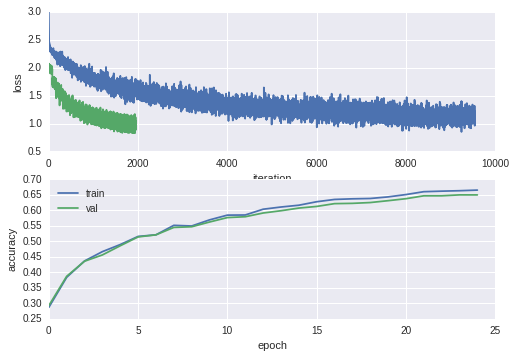

In [15]:
plt.subplot(2, 1, 1)
plt.plot(np.array(loss_history).clip(max=3))
plt.plot(np.array(loss_test_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

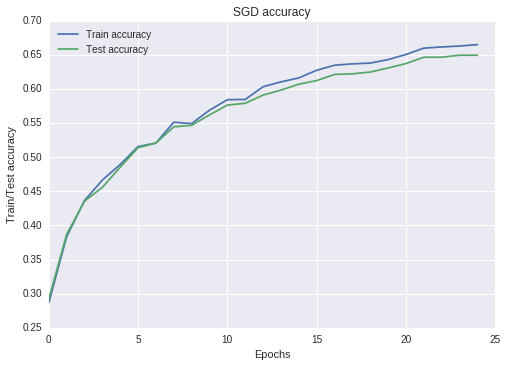

In [21]:
x = xrange(0,len(train_acc_history))
sigmoid_train = train_acc_history
sigmoid_test = val_acc_history
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("SGD accuracy")
sns.plt.legend(loc='upper left')

In [19]:
train_loss = [2.212988,1.971268,1.810139,1.702147,1.622690,1.560921,1.506539,1.457660,1.414620,1.378237,1.325807,1.310838,1.288516,1.265867,1.251472,1.231787,1.220118,1.202419,1.187745,1.177001,1.146426,1.136815,1.127049,1.123708,1.122088]
test_loss = [1.973428e+00,1.728926e+00,1.593626e+00,1.509232e+00,1.410331e+00,1.355635e+00,1.320439e+00,1.268900e+00,1.253325e+00,1.213673e+00,1.180485e+00,1.168069e+00,1.132358e+00,1.119597e+00,1.108791e+00,1.086188e+00,1.073905e+00,1.056318e+00,1.048264e+00,1.038111e+00,1.017377e+00,1.001293e+00,9.975208e-01,9.903925e-01,9.921992e-01]

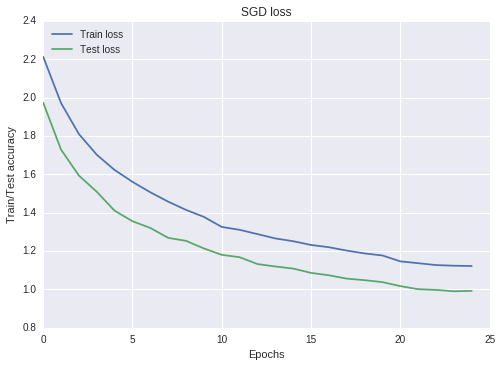

In [20]:
x = xrange(0,len(train_loss))
sigmoid_train = train_loss
sigmoid_test = test_loss
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train loss" )
sns.plt.plot(x, sigmoid_test,  label = "Test loss" )
sns.plt.title("SGD loss")
sns.plt.legend(loc='upper left')